In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [5]:
spotify_df = pd.read_csv('tracks.csv')

In [6]:
spotify_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [7]:
data_w_genre = pd.read_csv('data_by_artist_o.csv')
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [8]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [9]:
data_w_genre['genres'].values[0][0]

'['

In [10]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [11]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [12]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [13]:
spotify_df['artists'].values[0]

"['Uli']"

In [14]:
spotify_df['artists_upd_v1'].values[0][0]

'Uli'

In [15]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1
164,1xEEYhWxT4WhDQdxfPCT8D,Snake Rag,20,194533,0,"[""King Oliver's Creole Jazz Band""]",['08Zk65toyJllap1MnzljxZ'],1923,0.708,0.361,0,-11.764,0,0.0441,0.994,0.883,0.103,0.902,105.695,4,[]
170,3rauXVLOOM5BlxWqUcDpkg,Chimes Blues,14,170827,0,"[""King Oliver's Creole Jazz Band""]",['08Zk65toyJllap1MnzljxZ'],1923,0.546,0.189,0,-15.984,1,0.0581,0.996,0.908,0.339,0.554,80.318,4,[]
172,1UdqHVRFYMZKU2Q7xkLtYc,Pickin' On Your Baby,11,197493,0,"[""Clarence Williams' Blue Five""]",['6RuQvIr0t0otZHnAxXTGkm'],1923,0.520,0.153,0,-14.042,1,0.0440,0.995,0.131,0.353,0.319,102.937,4,[]
174,0Vl2DO5U6FjgBpzCtBN3OA,Everybody Loves My Baby,10,152507,0,"[""Clarence Williams' Blue Five""]",['6RuQvIr0t0otZHnAxXTGkm'],1923,0.514,0.193,2,-13.920,0,0.2380,0.996,0.199,0.248,0.665,180.674,4,[]
180,5SvyP1ZeJX1jA7AOZD08NA,Tears,10,187227,0,"[""King Oliver's Creole Jazz Band""]",['08Zk65toyJllap1MnzljxZ'],1923,0.359,0.357,3,-11.810,1,0.0511,0.994,0.819,0.290,0.753,205.053,4,[]


In [16]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [17]:
spotify_df.tail()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.518,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,[阿YueYue],[],[阿YueYue]
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.663,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,[ROLE MODEL],[],[ROLE MODEL]
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.314,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,[FINNEAS],[],[FINNEAS]
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"['Gentle Bones', 'Clara Benin']","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.615,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,"[Gentle Bones, Clara Benin]",[],"[Gentle Bones, Clara Benin]"
586671,5Ocn6dZ3BJFPWh4ylwFXtn,Mar de Emociones,38,214360,0,['Afrosound'],['0i4Qda0k4nf7jnNHmSNpYv'],2015-07-01,0.686,0.723,6,-7.067,1,0.0363,0.105,0.000000,0.2640,0.9750,112.204,4,[Afrosound],[],[Afrosound]


In [18]:
spotify_df['artists_song'] = spotify_df.apply(lambda row: str(row['artists_upd'][0])+ " " + str(row['name']),axis = 1)

In [19]:
spotify_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[Uli],[],[Uli],Uli Carve
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[Fernando Pessoa],[],[Fernando Pessoa],Fernando Pessoa Capítulo 2.16 - Banquero Anarq...
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,[Ignacio Corsini],[],[Ignacio Corsini],Ignacio Corsini Vivo para Quererte - Remasteri...
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,[Ignacio Corsini],[],[Ignacio Corsini],Ignacio Corsini El Prisionero - Remasterizado
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,[Dick Haymes],[],[Dick Haymes],Dick Haymes Lady of the Evening


In [20]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [21]:
spotify_df[spotify_df['name']=='Adore You']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
86217,5AnCLGg35ziFOloEnXK4uu,Adore You,71,278747,0,['Miley Cyrus'],['5YGY8feqx7naU7z4HrwZM6'],2013-10-04,0.583,0.655,0,-5.407,1,0.0315,0.1110,0.000004,0.113,0.201,119.759,4,[Miley Cyrus],[],[Miley Cyrus],Miley Cyrus Adore You
91884,3jjujdWJ72nww5eGnfs2E7,Adore You,88,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-13,0.676,0.771,8,-3.675,1,0.0483,0.0237,0.000007,0.102,0.569,99.048,4,[Harry Styles],[],[Harry Styles],Harry Styles Adore You
92524,1M4qEo4HE3PRaCOM7EXNJq,Adore You,74,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-06,0.676,0.771,8,-3.675,1,0.0483,0.0237,0.000007,0.102,0.569,99.048,4,[Harry Styles],[],[Harry Styles],Harry Styles Adore You


In [22]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [23]:

spotify_df[spotify_df['name']=='Adore You']

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
86217,5AnCLGg35ziFOloEnXK4uu,Adore You,71,278747,0,['Miley Cyrus'],['5YGY8feqx7naU7z4HrwZM6'],2013-10-04,0.583,0.655,0,-5.407,1,0.0315,0.1110,0.000004,0.113,0.201,119.759,4,[Miley Cyrus],[],[Miley Cyrus],Miley Cyrus Adore You
91884,3jjujdWJ72nww5eGnfs2E7,Adore You,88,207133,0,['Harry Styles'],['6KImCVD70vtIoJWnq6nGn3'],2019-12-13,0.676,0.771,8,-3.675,1,0.0483,0.0237,0.000007,0.102,0.569,99.048,4,[Harry Styles],[],[Harry Styles],Harry Styles Adore You


In [24]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [25]:
artists_exploded.head()

,artists_upd,id
538433,최진희,3u1C6nWVRoP5F0w8gGrDL3
404349,지수,1Mv4u308L16NZDZiD6HZCy
210091,지선,1jvoY322nxyKXq8OBhgmSY
270610,조정현,2ghebdwe2pNXT4eL34T7pW
208974,장정우,7rxpWwcXNgDUXl0wN0gUvp


In [26]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [27]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_upd
170329,Robert Schumann,6KuQTIu1KoTTkLXKrwlLPV,"['classical', 'early romantic era', 'german ro...",Robert Schumann,0.985304,0.362467,212896.341667,0.102329,0.783424,0.154049,-22.896354,0.047962,97.550958,0.274555,3.195833,5.0,1.0,240.0,"[classical, early_romantic_era, german_romanti..."
170330,Vladimir Horowitz,6KuQTIu1KoTTkLXKrwlLPV,"['classical', 'classical performance', 'classi...",Vladimir Horowitz,0.990092,0.343624,266650.370833,0.118341,0.879898,0.182788,-23.190868,0.043228,94.845258,0.224994,3.694167,1.0,1.0,1200.0,"[classical, classical_performance, classical_p..."


In [28]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [29]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [30]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[power_pop, dance_rock, rock, permanent_wave, ..."
1,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[classic_bollywood, sufi, ghazal, classic_paki..."
2,000P83HDtOHcNVFZy7Q2Yu,"[[boogaloo, latin_jazz, salsa, salsa_puertorri...","[salsa, boogaloo, tropical, salsa_puertorrique..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[piano_blues, ragtime, boogie-woogie, stride]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [31]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')


In [32]:
spotify_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
0,3u1C6nWVRoP5F0w8gGrDL3,사랑의 미로,25,222380,0,['최진희'],['1NSrAf8XJYJVgAXKoxaMet'],1987-06-01,0.367,0.194,7,-19.057,1,0.0400,0.617,0.000006,0.1620,0.367,144.316,4,[최진희],[],[최진희],최진희 사랑의 미로,NaN
1,1Mv4u308L16NZDZiD6HZCy,사랑은 힘든가봐,28,213440,0,['지수'],['4c9QIMfEbIIynuaswyxGx9'],2005-12-23,0.675,0.785,4,-5.026,0,0.0280,0.379,0.000000,0.3530,0.623,103.008,4,[지수],[],[지수],지수 사랑은 힘든가봐,NaN
2,1jvoY322nxyKXq8OBhgmSY,어떡하죠,44,244360,0,['지선'],['2Mo9NQaNCFCWSR5CnlfmbN'],2011-10-13,0.606,0.341,0,-7.094,1,0.0513,0.779,0.000000,0.1440,0.294,135.667,4,[지선],[],[지선],지선 어떡하죠,NaN
3,2ghebdwe2pNXT4eL34T7pW,그아픔까지사랑한거야,32,237688,0,['조정현'],['2WTpsPucygbYRnCnoEUkJQ'],1989-06-15,0.447,0.215,10,-16.478,1,0.0272,0.568,0.000001,0.0649,0.177,71.979,4,[조정현],[],[조정현],조정현 그아픔까지사랑한거야,[classic_korean_pop]
4,7rxpWwcXNgDUXl0wN0gUvp,천국의 기억 장정우 Version,31,280372,0,['장정우'],['5L7zKs2ftwENWOMI7LFaN1'],2003-12-24,0.494,0.656,7,-6.347,0,0.0262,0.659,0.000007,0.1110,0.420,82.003,4,[장정우],[],[장정우],장정우 천국의 기억 장정우 Version,NaN


In [33]:
print(spotify_df[spotify_df['artists'] == "['Greta Van Fleet']"])

                            id                name  popularity  duration_ms  \
343768  1BfR5GMOgW0peHkPxrwf11         Safari Song          65       234600   
343769  7aOor99o8NNLZYElOXlBG1        Highway Tune          70       180640   
343770  32BEasyNQgqXQJKoVa0fUw  Black Smoke Rising          66       259893   

        explicit              artists                  id_artists  \
343768         0  ['Greta Van Fleet']  ['4NpFxQe2UvRCAjto3JqlSl']   
343769         0  ['Greta Van Fleet']  ['4NpFxQe2UvRCAjto3JqlSl']   
343770         0  ['Greta Van Fleet']  ['4NpFxQe2UvRCAjto3JqlSl']   

       release_date  danceability  energy  key  loudness  mode  speechiness  \
343768   2017-11-10         0.362   0.928    2    -4.015     1       0.0503   
343769   2017-11-10         0.582   0.962    4    -3.037     1       0.0542   
343770   2017-11-10         0.558   0.902    7    -4.018     1       0.0464   

        acousticness  instrumentalness  liveness  valence    tempo  \
343768        0.164

In [34]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [35]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [36]:
ohe_cols = 'popularity'

In [37]:
spotify_df['popularity'].describe()

count    523475.000000
mean         27.235870
std          18.030233
min           0.000000
25%          13.000000
50%          27.000000
75%          40.000000
max          99.000000
Name: popularity, dtype: float64

In [38]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [39]:
spotify_df1 = spotify_df.copy()
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [40]:
print(spotify_df[spotify_df['artists'] == "['Greta Van Fleet']"])

                            id                name  popularity  duration_ms  \
343768  1BfR5GMOgW0peHkPxrwf11         Safari Song          65       234600   
343769  7aOor99o8NNLZYElOXlBG1        Highway Tune          70       180640   
343770  32BEasyNQgqXQJKoVa0fUw  Black Smoke Rising          66       259893   

        explicit              artists                  id_artists  \
343768         0  ['Greta Van Fleet']  ['4NpFxQe2UvRCAjto3JqlSl']   
343769         0  ['Greta Van Fleet']  ['4NpFxQe2UvRCAjto3JqlSl']   
343770         0  ['Greta Van Fleet']  ['4NpFxQe2UvRCAjto3JqlSl']   

       release_date  danceability  energy  key  loudness  mode  speechiness  \
343768   2017-11-10         0.362   0.928    2    -4.015     1       0.0503   
343769   2017-11-10         0.582   0.962    4    -3.037     1       0.0542   
343770   2017-11-10         0.558   0.902    7    -4.018     1       0.0464   

        acousticness  instrumentalness  liveness  valence    tempo  \
343768        0.164

In [41]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [42]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [43]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)

In [44]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house  \
0                     0.0              0.0              0.0               0.0   
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   genre|acid_rock  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0              0.0                0.0               0.0             0.0   
1              0.0                0.0               0.0             0.0   
2              0.0                0.0               0.0             0.0   
3              0.0                0.0               0.0             0.0   
4              0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_pop  genre|acoustic_punk  \
0                   0.0                 0.0                  0.0   
1                   0.0                 0.0                  0.0   
2                   0.0                 0.0                  0.0   
3                   0.0                 0.0                  0.0   
4                   0.0                 0.0                  0.0   

   genre|acoustic_rock  genre|adoracion  genre|adult_standards  \
0                  0.0              0.0                    0.0   
1                  0.0              0.0                    0.0   
2                  0.0              0.0                    0.0   
3                  0.0              0.0                    0.0   
4                  0.0              0.0                    0.0   

   genre|adventista  genre|afghan_pop  genre|afghan_traditional  \
0               0.0               0.0                       0.0   
1               0.0               0.0                       0.0   
2               0.0               0.0                       0.0   
3               0.0               0.0                       0.0   
4               0.0               0.0                       0.0   

   genre|african  genre|african_percussion  genre|african_reggae  \
0            0.0                       0.0                   0.0   
1            0.0                       0.0                   0.0   
2            0.0                       0.0                   0.0   
3            0.0                       0.0                   0.0   
4            0.0                       0.0                   0.0   

   genre|african_rock  genre|afro  genre|afro_dancehall  genre|afro_house  \
0                 0.0         0.0                   0.0               0.0   
1                 0.0         0.0                   0.0               0.0   
2                 0.0         0.0                   0.0               0.0   
3                 0.0         0.0                   0.0               0.0   
4                 0.0         0.0                   0.0               0.0   

   genre|afro_psych  genre|afro_soul  genre|afrobeat  genre|afrofuturism  \
0               0.0              0.0             0.0                 0.0   
1               0.0              0.0             0.0                 0.0   
2   

In [45]:
#print(complete_feature_set[complete_feature_set['id'] == "32BEasyNQgqXQJKoVa0fUw"])

In [46]:
client_id = 'ca5d9b9710bd471baff916850b4e8490'
client_secret = '39e696f46e8848b292b18c242af9409f'

In [47]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [48]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [49]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [50]:
sp = spotipy.Spotify(auth=token)

In [51]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [52]:
id_name

{'My Playlist #1': '7nISMCftMmrrdPgB1qxQaN'}

In [53]:

def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [54]:
playlist_luca = create_necessary_outputs('My Playlist #1', id_name,spotify_df)

In [55]:
#!pip install skimage

In [56]:
#!pip install -U scikit-image

In [57]:
#!pip install --upgrade pip

In [58]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [59]:
playlist_luca

,artist,name,id,url,date_added
39,Mattafix,Big City Life,4stm6lf1vQBSl7Eq4Npzr0,https://i.scdn.co/image/ab67616d00001e02dfbe03...,2021-06-01 14:34:07+00:00
38,Gary Clark Jr.,Bright Lights,2NTDt9Fiqp5wTBM6cLO6Bu,https://i.scdn.co/image/ab67616d00001e025a4e89...,2021-06-01 14:33:53+00:00
37,Red Hot Chili Peppers,Give It Away,0uppYCG86ajpV2hSR3dJJ0,https://i.scdn.co/image/ab67616d00001e02153d79...,2021-06-01 14:33:36+00:00
35,Placebo,Post Blue,43Mhu1qi3qI2G2544mgelo,https://i.scdn.co/image/ab67616d00001e025a95bd...,2021-06-01 14:33:09+00:00
34,JAY-Z,No Church In The Wild,3Osd3Yf8K73aj4ySn6LrvK,https://i.scdn.co/image/ab67616d00001e024a7677...,2021-06-01 14:32:58+00:00
33,The Weeknd,Pray For Me (with Kendrick Lamar),77UjLW8j5UAGAGVGhR5oUK,https://i.scdn.co/image/ab67616d00001e02c027ad...,2021-06-01 14:32:51+00:00
32,Queen,You Don't Fool Me - Remastered 2011,1chxAv59LZcOE5FyrlUze2,https://i.scdn.co/image/ab67616d00001e0295b06b...,2021-06-01 14:32:41+00:00
30,The Knife,Marble House,59mg5dz40MDexOTFHYRBAb,https://i.scdn.co/image/ab67616d00001e023b0fe7...,2021-06-01 14:31:45+00:00
29,The Blaze,Territory,2W3EgJst61RLZtPPm3EQim,https://i.scdn.co/image/ab67616d00001e02cdc2c3...,2021-06-01 14:31:16+00:00
28,Muse,Knights of Cydonia,7ouMYWpwJ422jRcDASZB7P,https://i.scdn.co/image/ab67616d00001e0228933b...,2021-06-01 14:31:03+00:00


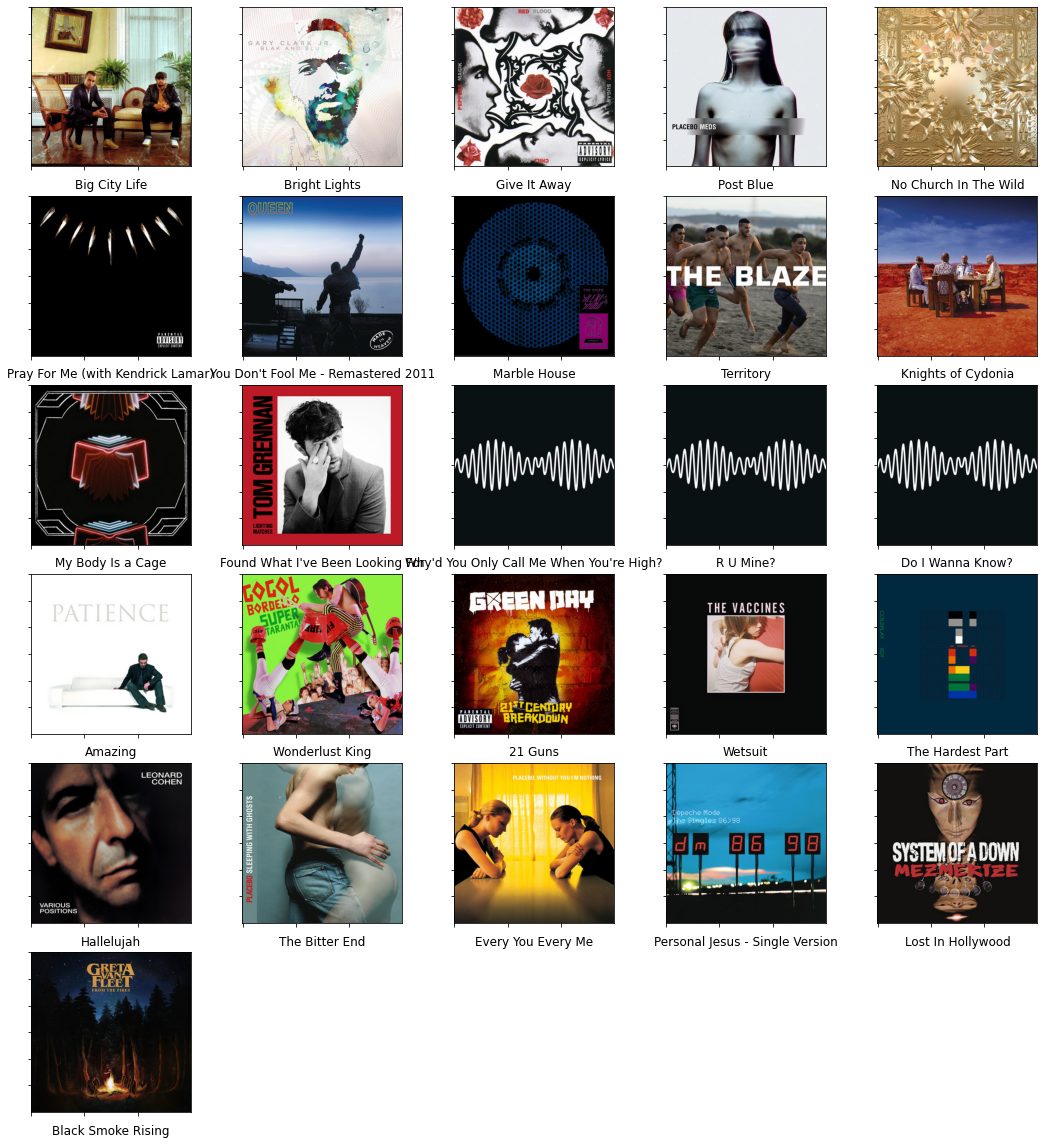

In [60]:
visualize_songs(playlist_luca)

In [61]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [62]:
complete_feature_set_playlist_vector_luca, complete_feature_set_nonplaylist_luca = generate_playlist_feature(complete_feature_set, playlist_luca, 1.09)

In [63]:
complete_feature_set_playlist_vector_luca.shape

(2945,)

In [70]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    #non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [74]:
luca_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_luca, complete_feature_set_nonplaylist_luca)

In [75]:
luca_top40

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,year,popularity_red,sim
196572,3lPr8ghNDBLc2uZovNyLs9,Supermassive Black Hole,76,212440,0,['Muse'],['12Chz98pHFMPJEknJQMWvI'],2006-06-19,0.668,0.921,7,-3.727,1,0.0439,0.049200,0.005170,0.0877,0.7820,120.000,4,[Muse],[],[Muse],Muse Supermassive Black Hole,"[rock, permanent_wave, modern_rock]",2006,15,0.723096
196593,5YXr4AGfUQpLSxtFSsKUh6,Map of the Problematique,58,258066,0,['Muse'],['12Chz98pHFMPJEknJQMWvI'],2006-06-19,0.493,0.959,8,-3.613,1,0.0414,0.000386,0.118000,0.2540,0.7030,125.040,4,[Muse],[],[Muse],Muse Map of the Problematique,"[rock, permanent_wave, modern_rock]",2006,11,0.722277
69006,2aZ2Co4NeQRsqWcU930zHT,Shot At The Night,65,242507,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2013-01-01,0.510,0.802,5,-4.903,1,0.0561,0.091700,0.013600,0.1090,0.2400,185.927,4,[The Killers],[],[The Killers],The Killers Shot At The Night,"[rock, permanent_wave, modern_rock]",2013,13,0.718884
69021,6suRRwX61xSMfU7wJuCVdy,For Reasons Unknown,60,212267,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2006-09-27,0.504,0.884,3,-4.214,1,0.0366,0.000458,0.039900,0.1080,0.5160,140.398,4,[The Killers],[],[The Killers],The Killers For Reasons Unknown,"[rock, permanent_wave, modern_rock]",2006,12,0.717129
69025,4shKoD4U0rsE6UDjyPEjyK,Bones,59,227000,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2006-09-27,0.472,0.902,9,-3.607,1,0.0643,0.000679,0.124000,0.0822,0.5670,139.570,4,[The Killers],[],[The Killers],The Killers Bones,"[rock, permanent_wave, modern_rock]",2006,11,0.716844
69011,7cX4PJz1old9fyFI8RlfgW,Read My Mind,71,246840,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2006-09-27,0.543,0.917,1,-3.391,1,0.0444,0.005720,0.000078,0.1040,0.3290,132.246,4,[The Killers],[],[The Killers],The Killers Read My Mind,"[rock, permanent_wave, modern_rock]",2006,14,0.715617
196575,3skn2lauGk7Dx6bVIt5DVj,Starlight,74,240213,0,['Muse'],['12Chz98pHFMPJEknJQMWvI'],2006-06-19,0.550,0.874,4,-4.046,1,0.0321,0.000436,0.000010,0.2060,0.3180,121.610,4,[Muse],[],[Muse],Muse Starlight,"[rock, permanent_wave, modern_rock]",2006,14,0.713570
69026,1Rr17slUHwVRkDz4A2TUcM,Bling (Confession Of A King),52,248467,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2006-09-27,0.532,0.931,11,-3.662,0,0.0467,0.001440,0.263000,0.1590,0.3830,113.424,4,[The Killers],[],[The Killers],The Killers Bling (Confession Of A King),"[rock, permanent_wave, modern_rock]",2006,10,0.713204
68999,70wYA8oYHoMzhRRkARoMhU,When You Were Young,77,220427,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2006-09-27,0.467,0.988,11,-3.313,1,0.1120,0.000152,0.048400,0.2800,0.3210,130.433,4,[The Killers],[],[The Killers],The Killers When You Were Young,"[rock, permanent_wave, modern_rock]",2006,15,0.713016
69008,77Kh98jRHI40rIAKnBs7cl,Sam's Town,55,246027,0,['The Killers'],['0C0XlULifJtAgn6ZNCW2eu'],2006-09-27,0.268,0.960,6,-4.596,0,0.0963,0.000217,0.006040,0.7320,0.4400,141.415,4,[The Killers],[],[The Killers],The Killers Sam's Town,"[rock, permanent_wave, modern_rock]",2006,11,0.712323


In [77]:
luca_top40[['id', 'artists_song']]

,id,artists_song
196572,3lPr8ghNDBLc2uZovNyLs9,Muse Supermassive Black Hole
196593,5YXr4AGfUQpLSxtFSsKUh6,Muse Map of the Problematique
69006,2aZ2Co4NeQRsqWcU930zHT,The Killers Shot At The Night
69021,6suRRwX61xSMfU7wJuCVdy,The Killers For Reasons Unknown
69025,4shKoD4U0rsE6UDjyPEjyK,The Killers Bones
69011,7cX4PJz1old9fyFI8RlfgW,The Killers Read My Mind
196575,3skn2lauGk7Dx6bVIt5DVj,Muse Starlight
69026,1Rr17slUHwVRkDz4A2TUcM,The Killers Bling (Confession Of A King)
68999,70wYA8oYHoMzhRRkARoMhU,The Killers When You Were Young
69008,77Kh98jRHI40rIAKnBs7cl,The Killers Sam's Town
